# EGG data challenge - group7

* GARDE FAHIM

---

## imports & setup

note that experiments were run in the Colab environement to benefit from GPU

In [ ]:
!pip install mne

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from  pathlib import Path
from os import listdir 
from fastai.vision import *
from fastai.callbacks import * 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
home = Path('/content/drive/My Drive/AML')
work = Path('/content/work/')
work.mkdir(exist_ok=True)

---
## First Thoughs

The neural network is defined in the paper [EEGNet:  A Compact Convolutional Neural Networkfor EEG-based Brain-Computer Interfaces](https://arxiv.org/pdf/1611.08024.pdf) is not that deep.

We can observe that it uses uncommon convolutions by splitting the convolution kernel in two. Therefore we need way less parameters than usual. This splitting "makes sense" in the EGG framework because it corresponds to separately perform analyses on different frequency scales.

The "weird" thing, which means to be investigated, is that replacing those 2-steps convolutions by common 2D conv gives worse results with regards to individual scores. 

The paper points out that it is likely due to the lack of data. Indeed, the "full convolutions" networks have, in order of magnitude, more parameters. 

In my opinion, it means one things:
* With not enough data, the network is overfitting on it. 

So we need a way to have more data.

Given this, I really want to try using **transfert learning** from the cross subject network to bootstrap per-subjects networks.
So we will have both a model that has learnt from a lot of data, and a finetuned model for each subject.

One a side note, if we had a lot of data, we could use only classic convolutions. Yet this might not be wanted:

* using conv2d only makes interpretablity harder, since you can't interpret the weights as spacial and temporal filters: they are now a mix of both. 
* using a bigger network makes inference slower, which can be really bad in an interactive system like the BCI.

We tried using classic conv2d instead of the separable one without great results.

--- 
## Getting the dataset

In [ ]:
from  shutil import rmtree

In [ ]:
import tarfile, zipfile

In [ ]:
if not Path(work/'eeg').is_dir():
  with tarfile.open(home/'egg.zip') as egg:
    egg.extractall(work)
    
with zipfile.ZipFile(home/'ebci_data_loader-master.zip') as data_loader:
  data_loader.extractall(work)

---
## Data loading and visualistion

### Reading the electrodes

In [ ]:
import sys

In [ ]:
sys.path.append(str(work/'ebci_data_loader-master'))

In [ ]:
from data import DataBuildClassifier

In [ ]:
#load the data in  subjects
data_loader = DataBuildClassifier(str(work/'eeg')) #Path to directory with data (i.e NewData contatins 25/, 26/ ....)
all_subjects = [25, 26,27,28,29,30,32,33,34,35,36,37,38]
subjects = data_loader.get_data(all_subjects,shuffle=False, windows=[(0.2,0.5)],baseline_window=(0.2,0.3),)
X,y = subjects[25]

In [ ]:
#get the electrodes positions
electrodes=[]
with open(work/'eeg/order_locations.info') as f:
  f.readline()
  for line in f.readlines():
    i,d,r,n=line.rstrip().split("\t")
    electrodes.append([int(i), int(d), float(r), str(n.strip())])

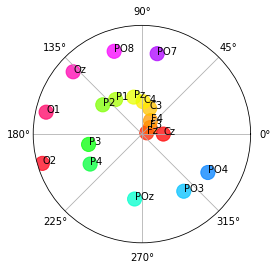

In [ ]:
index,deg,theta,name = zip(*electrodes)

# Compute areas and colors
N = 150
r = np.array(index)
theta = np.array(theta) * r
area = 200
colors = theta

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.set_yticks([])
ax.scatter(theta, r, c=colors, s=area, cmap='hsv', alpha=0.75, )
for n, t,ri in zip(name, theta, r):
  ax.annotate(n,(t,ri))

Distances from the center are abitrary.
We have been able to load correctly the different electrodes.

In [ ]:
electrodes = {n:i for i,n in enumerate(name)}

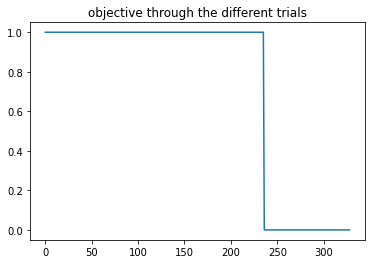

In [ ]:
plt.plot(y)
plt.title("objective through the different trials")
plt.show()

We have to be careful there, data is sorted.

### Observing the data

13


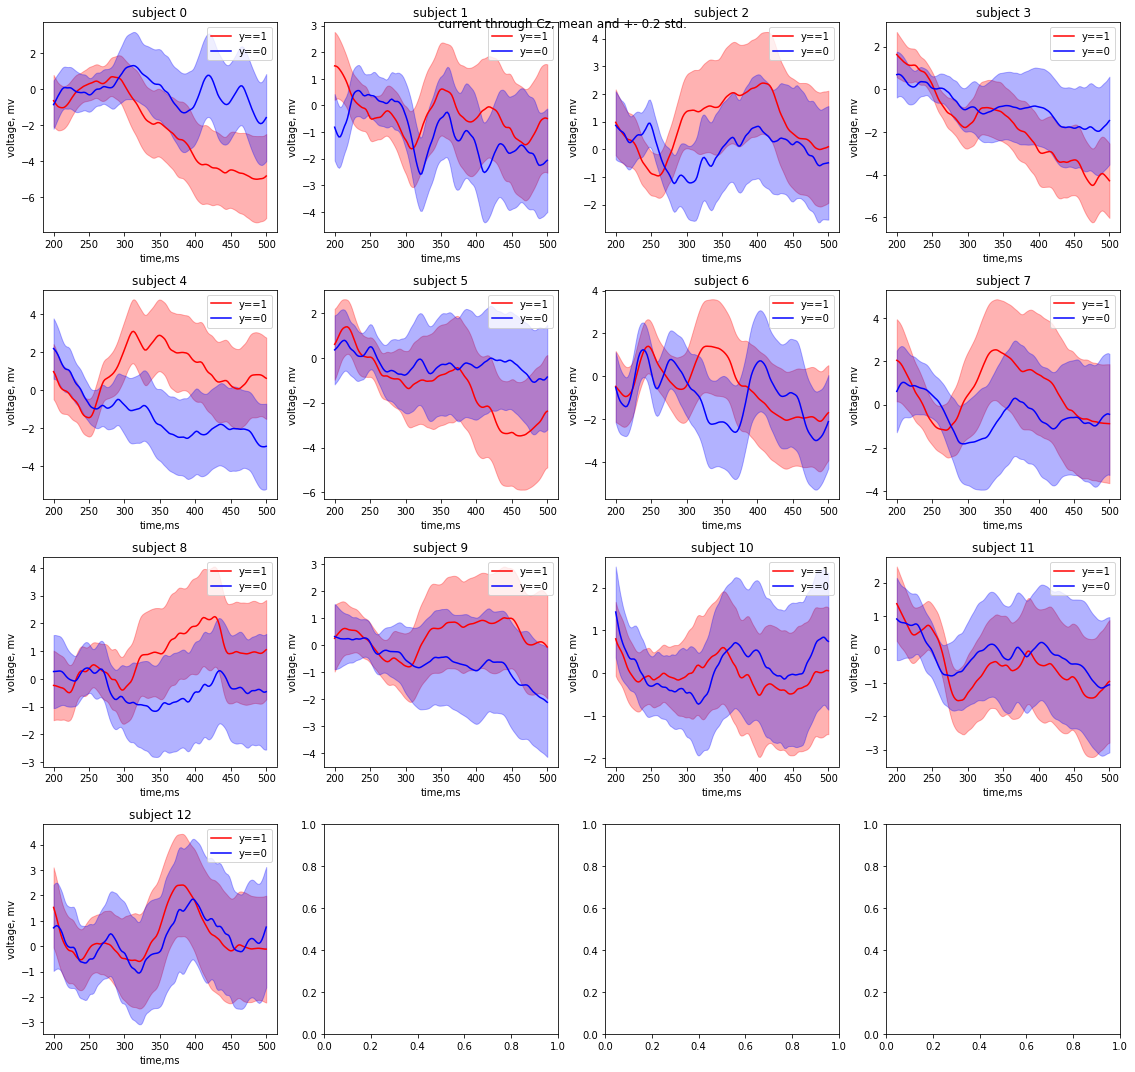

In [ ]:
N = len(subjects.keys())
print(N)
fig, axs=plt.subplots(4,4,figsize =(16,15))
axs=axs.ravel()
fig.set_tight_layout(True)
fig.subplots_adjust(top=0.6)
for i,(X,y) in enumerate(subjects.values()):
  ax=axs[i]
  pos=X[y==1,:,electrodes["Cz"]]
  neg=X[y==0,:,electrodes["Cz"]]
  x=np.linspace(200, 500, len(X[1]))
  ax.set_title(f"subject {i}")
  ax.plot(x,pos.mean(axis=0), c='r', label="y==1")
  ax.plot(x,neg.mean(axis=0), c='b', label="y==0")
  ax.fill_between(x, pos.mean(axis=0)+0.2*pos.std(axis=0), pos.mean(axis=0)-0.2*pos.std(axis=0), alpha=0.3,color="r")
  ax.fill_between(x, neg.mean(axis=0)+0.2*neg.std(axis=0), neg.mean(axis=0)-0.2*neg.std(axis=0), alpha=0.3,color='b')
  ax.legend()
  ax.set_xlabel("time,ms")
  ax.set_ylabel("voltage, mv")

  plt.suptitle("current through Cz, mean and +- 0.2 std.")
plt.show()


nota: 
we test on Cz since according to the reading sources, it is one of the most intersting channels to observe the response.

the first subject has indeed some divergence between y==1 and y==0 in Cz. As for the other, it is more complicated!


---
## Creating the classifier

### Basic building blocs

We define the Depthwise and Separable convolutions used in the paper.

In [ ]:
class Unsqueeze(nn.Module):
    def __init__(self, channel):
        super(Unsqueeze, self).__init__()
        self.channel=channel
    def forward(self, x):
        return x.unsqueeze(self.channel)

    def __repr__(self):
        return 'unsqueeze(nB,...,1, ...)'

In [ ]:
class DepthwiseConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel,**args):
        super(DepthwiseConv2D, self).__init__()
        self.args=args
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.kernel=kernel
        self.conv=nn.Conv2d(self.in_channels,self.out_channels,self.kernel, groups=self.in_channels,**args)

    def forward(self, x):
        return self.conv.forward(x)

    def __repr__(self):
        return "Depthwise "+self.conv.__repr__()

In [ ]:
class SeparableConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel,**args):
        super(SeparableConv2D, self).__init__()
        self.args=args
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.kernel=kernel
        self.depthwise=nn.Conv2d(self.in_channels,self.in_channels ,self.kernel, padding=(self.kernel[0]//2, self.kernel[1]//2), groups=self.in_channels,**args)
        self.pointwise=nn.Conv2d(self.in_channels, self.out_channels, (1,1))

    def forward(self, x):
        return self.pointwise.forward(self.depthwise.forward(x))

    def __repr__(self):
        return f"separable in: {self.in_channels}, out:{self.out_channels}, kernel:{self.kernel}"

### The architecture

---
We build upon the baseline model: 

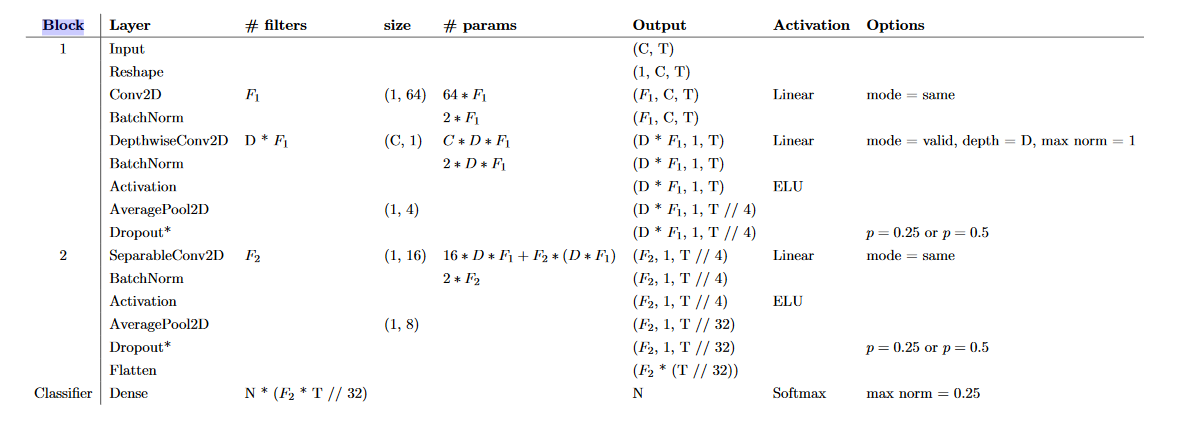

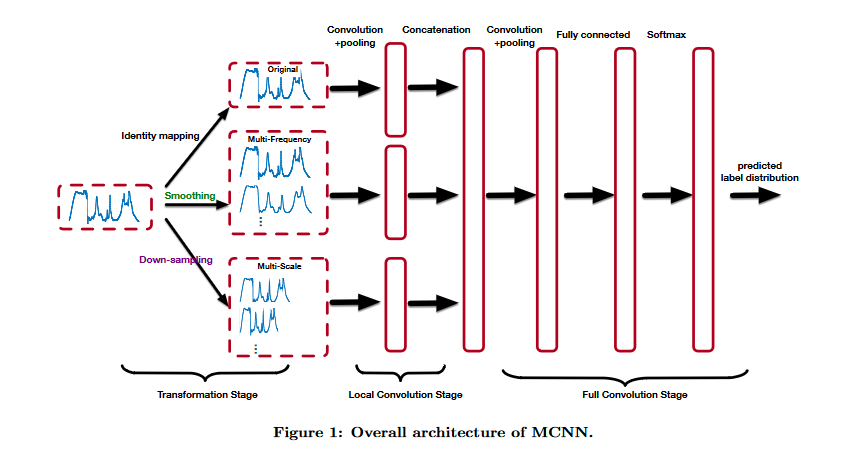

from [this paper](https://arxiv.org/pdf/1603.06995.pdf), we can perform some data augmentation by using several different versions of the data. 

I wonder how effective it is. The baseline architecture already have different versions after the first conv2d in the block 1, but instead of doing it by hand, it automatically learns the best filters for it.

Our version simply has a bigger `F1` that capture this data versionning.

In [ ]:
def baseline(C,T,N=2, F1=20, D=8, F2=None, p=0.5):
  if not F2:
    F2 = D*F1
  sprate=500
  conv1size=sprate//2 #half the sampling rate as per the paper.

  block1 = [
            Unsqueeze(1),
            nn.Conv2d(1, F1, (1,conv1size), stride=1, padding=(0,conv1size//2), dilation=1, groups=1, bias=False, padding_mode='zeros'),
            nn.BatchNorm2d(F1),
            DepthwiseConv2D(F1, D*F1, (C,1)),
            nn.BatchNorm2d(D*F1),
            nn.ELU(),
            nn.AvgPool2d((1,4)),
            nn.Dropout(p)
            ]
  block2 = [
            SeparableConv2D(D*F1, F2, (1, sprate//8)),#as per the paper
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.AvgPool2d((1,8)),
            nn.Dropout(p=0.3),
            
            ]
  classifier = [
                nn.Flatten(),
                nn.ELU(),
                nn.Linear(F2*(T//32),F2*(T//32),bias=True),
                nn.ELU(),
                nn.Linear(F2*(T//32),N,bias=False),
  ]
  return nn.Sequential(*(block1+block2+classifier))

Nota: 

We choose to keep the sampling rate at 500Hz, and it is here hardcoded in the model architecture. This affects the size of the the two convolutionnal filers that were originaly (1,64) and (1, 16). The paper derives thoses number from the sampling original sampling rate of 128Hz. We have updated it for 500Hz.

We also have an additional `Linear` + `ELU` layer. This additionnal layer comes from an attempt at [Discriminative layer training](https://docs.fast.ai/basic_train.html#Discriminative-layer-training). Where we would only refine a global model for each subject by only updating the last two linear layers.

Our main parameters are :


* `F1` is 20
* `D` is 8
* `F2` like in the paper is `F1`x`D`. 


### formating the data

In [ ]:
#Split are sequentials to respect the time depency.
from sklearn.model_selection import train_test_split
def split(x,y,test_p=.2):
  label_split = lambda i: train_test_split(x[y==i], y[y==i].reshape(-1,1), shuffle=False,test_size=test_p)
  return [np.vstack([u, v]) for u,v in zip(label_split(0),label_split(1))]

In [ ]:
#simple class for fastai API
class ArrayDataset(Dataset):
    "Sample numpy array dataset"
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.c = 2 # binary label
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]


In [ ]:
#Puts the data into DataBunch as per fastai API. Needs the raw X,y from the subject
def make_data(X, y):
  1#some reformatting
  X=np.swapaxes(X, 1,2).astype(np.float32)
  y=y.astype(np.int)
  #split train / test.
  xt,xs,yt,ys=split(X,y)#split train / test
  xt,xv,yt,yv=split(xt,yt.reshape((-1,)))#split train / val
  #create the dataloader (fastAI API overlay)
  train = ArrayDataset(xt,yt.reshape((-1,)))
  test = ArrayDataset(xs,ys.reshape((-1,)))
  val = ArrayDataset(xv,yv.reshape((-1,)))
  data = DataBunch.create(train_ds=train, valid_ds=val, test_ds=test, bs=32)
  return data

--- 
## The trainning

training is done in two steps:

1.   Train on global data to obtain a base model
2.   Refine this model for each subject

The rational is that this bootstrapping forces the model to learn more general filters and so overfits less.


### trainning utilities

In [ ]:
#simple utility to create the model and add it to a learner.
def make_learner(data, model=baseline, loss_func=nn.CrossEntropyLoss ,**args):
    xb,yb=data.one_batch()
    C,T= xb.shape[1],xb.shape[2]
    model = model(C,T,)
    learn = Learner(data, model,loss_func=loss_func,**args)
    return learn

In [ ]:
metrics=[AUROC(), Precision(),Recall(),accuracy]
loss = nn.CrossEntropyLoss()
earlyStopping= partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.005, patience=10)

we keep track of auroc, precision, recall. It helps checking for imbalance in the learning process.

We use `crossEntropyloss` since it will be better that accuracy when training for auroc.

We use early stopping to get a faster process and avoid overfit.

### Training the model on the whole dataset

Not that data is carefully splited to ensure that any per-subject test data won't be in the global train set.

In [ ]:
1#get the data for all subjects
XT=[]
YT=[]
XV=[]
YV=[]
XS=[]
YS=[]
for i,(X,y) in enumerate(subjects.values()):
  X=np.swapaxes(X, 1,2).astype(np.float32)
  y=y.astype(np.int)
  #split train / test.
  xt,xs,yt,ys=split(X,y)#split train / test
  xt,xv,yt,yv=split(xt,yt.reshape((-1,)))#split train / val
  #create the dataloader (fastAI API overlay)
  XT.append(xt);YT.append(yt)
  XV.append(xv);YV.append(yv)
  XS.append(xs);YS.append(ys)
#create the dataloader (fastAI API overlay)
xt,yt=np.vstack(XT),np.vstack(YT)
xv,yv=np.vstack(XV),np.vstack(YV)
xs,ys=np.vstack(XS),np.vstack(YS)
train = ArrayDataset(xt,yt.reshape((-1,)))
test = ArrayDataset(xs,ys.reshape((-1,)))
val = ArrayDataset(xv,yv.reshape((-1,)))
data = DataBunch.create(train_ds=train, valid_ds=val, test_ds=test, bs=64)

In [ ]:
learn = make_learner(data, baseline, metrics=metrics, loss_func=loss, bn_wd=False,callback_fns=[])

In [ ]:
#find the best learning rate to use.
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


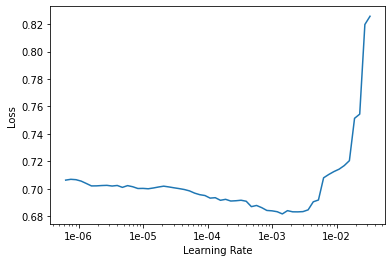

In [ ]:
learn.recorder.plot()

In [ ]:
#the actual learning 
learn.fit_one_cycle(20,1e-3)

epoch,train_loss,valid_loss,auroc,precision,recall,accuracy,time
0,0.658171,0.642353,0.651507,0.679030,0.704142,0.617462,00:01
1,0.652046,0.627479,0.671217,0.684673,0.806213,0.656166,00:01
2,0.653359,0.651376,0.625961,0.668883,0.744083,0.620162,00:01
3,0.652093,0.635960,0.650255,0.671717,0.786982,0.636364,00:01
4,0.645398,0.637288,0.670227,0.697872,0.727811,0.642664,00:01
5,0.632186,0.622572,0.677447,0.686122,0.782544,0.649865,00:01
6,0.629311,0.620797,0.681732,0.696599,0.757396,0.651665,00:01
7,0.624731,0.616605,0.689057,0.697283,0.797337,0.666067,00:01
8,0.622025,0.621788,0.681024,0.669065,0.825444,0.645365,00:01
9,0.617417,0.631625,0.657937,0.680556,0.797337,0.648965,00:01


In [ ]:
#save as first
learn.save("first")

We save the model at this step to eventually train it further.

In [ ]:
#save to bootstrap the per-subjects.
learn.save("global")

### refining per-subject

We made different attemps as per the learning rate, the discriminative layer training. 

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
#list to keep track of per subject scores
S=[]
V=[]

earlyStopping= partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.005, patience=20)

for i,(X,y) in enumerate(subjects.values()):
  print(i)
  data = make_data(X,y) #get the data.
  learn = make_learner(data, baseline, metrics=metrics, loss_func=loss, bn_wd=False,callback_fns=[earlyStopping, ],silent=True)
  learn.load("global") #use the global classifier wheigts as a starting point.

  #learn.split(lambda m: (m[14],)) #uncomment to fit only the last linear layers
  #learn.freeze(-1)  #uncomment to fit only the last linear layers
  
  save_best=SaveModelCallback(learn, every='improvement', monitor='auroc', name='best')
  
  learn.fit(100,1e-4, callbacks=[save_best])#learning rate of 1e-4 thought trials & errors.

  learn.load("best") #use the training epoch that had the best validation auroc

  #computing the scores.
  preds = learn.get_preds(DatasetType.Test)
  #preds contains the score for y==0 and y==1 and the true class.
  #preds[1]: true class, preds[0][1] is y==1 score.
  score = roc_auc_score(preds[1],[u[1].item() for u in preds[0] ]) 
  S.append(score)
  print(score)

  preds = learn.get_preds(DatasetType.Valid)
  score = roc_auc_score(preds[1],[u[1].item() for u in preds[0] ])
  V.append(score)


0


Better model found at epoch 0 with auroc value: 0.4929823875427246.
Better model found at epoch 1 with auroc value: 0.49824562668800354.
Better model found at epoch 2 with auroc value: 0.5035088062286377.
Better model found at epoch 6 with auroc value: 0.5228070020675659.
Better model found at epoch 7 with auroc value: 0.5263158082962036.
Better model found at epoch 8 with auroc value: 0.5333333611488342.
Better model found at epoch 9 with auroc value: 0.5350877046585083.
Better model found at epoch 11 with auroc value: 0.543859601020813.
Better model found at epoch 12 with auroc value: 0.5508772134780884.
Better model found at epoch 13 with auroc value: 0.5614035129547119.
Better model found at epoch 14 with auroc value: 0.5789474248886108.
Better model found at epoch 16 with auroc value: 0.5859649181365967.
Better model found at epoch 19 with auroc value: 0.5929824709892273.
Better model found at epoch 20 with auroc value: 0.5964912176132202.
Epoch 21: early stopping


0.5317982456140351


1


Better model found at epoch 0 with auroc value: 0.6807692050933838.
Better model found at epoch 1 with auroc value: 0.692307710647583.
Epoch 25: early stopping


0.6736842105263158


2


Better model found at epoch 0 with auroc value: 0.733187198638916.
Better model found at epoch 1 with auroc value: 0.7361111044883728.
Better model found at epoch 4 with auroc value: 0.7375730872154236.
Better model found at epoch 5 with auroc value: 0.7478070855140686.
Better model found at epoch 8 with auroc value: 0.7492690086364746.
Better model found at epoch 10 with auroc value: 0.7514620423316956.
Better model found at epoch 11 with auroc value: 0.7536550164222717.
Better model found at epoch 14 with auroc value: 0.7543860673904419.
Better model found at epoch 19 with auroc value: 0.7551169991493225.
Epoch 21: early stopping


0.7657407407407407


3


Better model found at epoch 0 with auroc value: 0.6023035645484924.
Better model found at epoch 1 with auroc value: 0.6233062744140625.
Better model found at epoch 2 with auroc value: 0.6429539322853088.
Better model found at epoch 3 with auroc value: 0.6605691313743591.
Better model found at epoch 4 with auroc value: 0.6890244483947754.
Better model found at epoch 5 with auroc value: 0.7188346982002258.
Better model found at epoch 6 with auroc value: 0.7425474524497986.
Better model found at epoch 7 with auroc value: 0.7479674816131592.
Better model found at epoch 8 with auroc value: 0.7527099847793579.
Better model found at epoch 11 with auroc value: 0.7547425031661987.
Better model found at epoch 12 with auroc value: 0.7588075399398804.
Better model found at epoch 13 with auroc value: 0.7594850659370422.
Epoch 28: early stopping


0.7965811965811965


4


Better model found at epoch 0 with auroc value: 0.7776057124137878.
Better model found at epoch 1 with auroc value: 0.7910216450691223.
Better model found at epoch 2 with auroc value: 0.8008255362510681.
Better model found at epoch 3 with auroc value: 0.8111454844474792.
Better model found at epoch 4 with auroc value: 0.8157894611358643.
Better model found at epoch 5 with auroc value: 0.8224973678588867.
Better model found at epoch 6 with auroc value: 0.8286893367767334.
Better model found at epoch 9 with auroc value: 0.829205334186554.
Epoch 25: early stopping


0.7972005208333334


5


Better model found at epoch 0 with auroc value: 0.7874395847320557.
Better model found at epoch 1 with auroc value: 0.793075680732727.
Better model found at epoch 2 with auroc value: 0.8075684309005737.
Better model found at epoch 3 with auroc value: 0.8228663206100464.
Better model found at epoch 4 with auroc value: 0.838164210319519.
Better model found at epoch 5 with auroc value: 0.8397745490074158.
Better model found at epoch 6 with auroc value: 0.8429951667785645.
Better model found at epoch 8 with auroc value: 0.8429952263832092.
Better model found at epoch 9 with auroc value: 0.8446055054664612.
Better model found at epoch 10 with auroc value: 0.8478261828422546.
Better model found at epoch 11 with auroc value: 0.8502416014671326.
Better model found at epoch 13 with auroc value: 0.8510467410087585.
Epoch 34: early stopping


0.7352941176470589


6


Better model found at epoch 0 with auroc value: 0.6856060028076172.
Better model found at epoch 1 with auroc value: 0.7045454382896423.
Better model found at epoch 2 with auroc value: 0.7222222089767456.
Better model found at epoch 3 with auroc value: 0.7234848141670227.
Better model found at epoch 4 with auroc value: 0.7260100841522217.
Better model found at epoch 8 with auroc value: 0.7285352945327759.
Better model found at epoch 19 with auroc value: 0.7398989796638489.
Better model found at epoch 20 with auroc value: 0.741161584854126.
Epoch 25: early stopping


0.6104417670682731


7


Better model found at epoch 0 with auroc value: 0.768627405166626.
Better model found at epoch 1 with auroc value: 0.7789215445518494.
Better model found at epoch 2 with auroc value: 0.7852941751480103.
Better model found at epoch 5 with auroc value: 0.7877451777458191.
Better model found at epoch 6 with auroc value: 0.7897059321403503.
Better model found at epoch 10 with auroc value: 0.7916667461395264.
Better model found at epoch 12 with auroc value: 0.7955882549285889.
Better model found at epoch 13 with auroc value: 0.7995098233222961.
Epoch 21: early stopping


0.8253968253968255


8


Better model found at epoch 0 with auroc value: 0.7544934153556824.
Better model found at epoch 1 with auroc value: 0.7716503739356995.
Better model found at epoch 2 with auroc value: 0.7933006286621094.
Better model found at epoch 3 with auroc value: 0.8010621070861816.
Better model found at epoch 4 with auroc value: 0.804330050945282.
Better model found at epoch 5 with auroc value: 0.811274528503418.
Better model found at epoch 6 with auroc value: 0.8133170008659363.
Better model found at epoch 15 with auroc value: 0.8169934153556824.
Epoch 26: early stopping


0.7638319672131147


9


Better model found at epoch 0 with auroc value: 0.7604081034660339.
Epoch 21: early stopping


0.7220921155347385


10


Better model found at epoch 0 with auroc value: 0.6671677827835083.
Better model found at epoch 1 with auroc value: 0.6791980266571045.
Better model found at epoch 2 with auroc value: 0.6852129697799683.
Better model found at epoch 3 with auroc value: 0.6917292475700378.
Better model found at epoch 4 with auroc value: 0.6987468004226685.
Better model found at epoch 5 with auroc value: 0.7022556066513062.
Better model found at epoch 6 with auroc value: 0.7127819657325745.
Better model found at epoch 7 with auroc value: 0.7147870063781738.
Better model found at epoch 8 with auroc value: 0.7192983031272888.
Better model found at epoch 9 with auroc value: 0.7238094806671143.
Better model found at epoch 11 with auroc value: 0.7263157963752747.
Better model found at epoch 13 with auroc value: 0.7268169522285461.
Better model found at epoch 14 with auroc value: 0.7273182272911072.
Better model found at epoch 15 with auroc value: 0.7333332896232605.
Better model found at epoch 16 with auroc va

0.7497543399934491


11


Better model found at epoch 0 with auroc value: 0.5930070281028748.
Better model found at epoch 1 with auroc value: 0.61993008852005.
Better model found at epoch 2 with auroc value: 0.6318182945251465.
Better model found at epoch 3 with auroc value: 0.6440558433532715.
Better model found at epoch 4 with auroc value: 0.6527971029281616.
Better model found at epoch 6 with auroc value: 0.6583915948867798.
Epoch 23: early stopping


0.6441471571906353


12


Better model found at epoch 0 with auroc value: 0.7104037404060364.
Better model found at epoch 1 with auroc value: 0.7146738767623901.
Better model found at epoch 2 with auroc value: 0.7232142686843872.
Better model found at epoch 8 with auroc value: 0.7251552939414978.
Epoch 21: early stopping


0.7025062656641603


---

## Conclusion

In [ ]:
print(f"auroc test: {np.mean(S):.4f}\nauroc validation {np.mean(V):.4f}")

auroc test: 0.7168
auroc validation 0.7485


we have a final auroc score of 0.7168, to be compared to the 0.6807 we obtained by running the solution notebook.

this is about 4 points higher, this is great! 